In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.linalg import circulant

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import os 
os.chdir('/Users/miguel/Documents/22-23/wimmer_lab/')
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

In [2]:
def circ_dist(x, y):
    return np.angle(np.exp(x * 1j) / np.exp(y * 1j))

def transfer_func(x):
    # input-output function for all cells, as in Rubin et al 2015
    return 0.04 * (np.maximum(x, np.zeros_like(x)) + 1) ** 2

In [3]:
class SSN:
    def __init__(self):
        parameters = np.array(['batchsize',       # number of trials that are simulated in one loop                     
                               'dt',              # simulation time step (s)
                               'dt_rate',         # results' resolution (ms)
                               'tmax',            # total time of the simulation
                               
                               # default neuron and network parameters
                               'NE',              # number of excitatory neurons
                               'NI',              # number of inhibitory neurons
                               'tauE',            # time constant of rate equation for excitatory neurons
                               'tauI',            # time constant of rate equation for inhibitory neurons
                               'tauF',            # factor to convert into firing rate
                               
                               'sigma_ori',       # parameter defining the width of Gaussian connection profiles
                               'GEE',             # strength of excitation to excitatory neurons
                               'GIE',             # strength of excitation to inhibitory neurons
                               'GEI',             # strength of inhibition to excitatory neurons
                               'GII',             # strength of inhibition to inhibitory neurons
                               'I0E',             # external bias current to excitatory neurons
                               'I0I',             # external bias current to inhibitory neurons
                               'tau_b',           # time constant of (noisy) background inputs (s)
                               
                               # default stimulus parameters
                               'tcue',            # cue (stimulus) period (s)
                               'sigma_stim_E',    # parameter defining the width of stimulus input
                               'sigma_stim_I',    # parameter defining the width of stimulus input
                               'I0_stim_E',       # strength of external stimulus
                               'I1_stim_E',       # strength of external stimulus
                               'I0_stim_I',       # strength of external stimulus
                               'I1_stim_I',       # strength of external stimulus
                               'th_stim'          # stimulus direction (rad)
                              ])  
        values = np.zeros(parameters.shape)
        self.params = dict(zip(parameters, values))
        
        
    def prep(self, **kwargs):
        self.params.update(kwargs.items())
        
        # ---------------------------------------------------
        # Set up network, depending on the default parameters
        # ---------------------------------------------------
    
        self.params.update({'N': self.params.get('NE') + self.params.get('NI')})    # total number of neurons

        # Set up connectivity 
        self.params.update({'theta': np.arange(self.params.get('NE')) / self.params.get('NE') * 2 * np.pi - np.pi})

        v = np.round(np.exp(np.round(- circ_dist(self.params.get('theta'), np.pi) ** 2, 4) / np.round(2 * self.params.get('sigma_ori') ** 2, 4)), 4)

        self.params.update({'W': np.vstack([np.hstack([self.params.get('GEE') / self.params.get('NE') * circulant(v), 
                                                       - self.params.get('GEI') / self.params.get('NI') * circulant(v)]),
                                            np.hstack([self.params.get('GIE') / self.params.get('NE') * circulant(v), 
                                                       - self.params.get('GII') / self.params.get('NI') * circulant(v)])])
                           })

        # the W matrix is structured like this:
        # [strength of E <- E connections       strength of E <- I connections]
        # [strength of I <- E connections       strength of I <- I connections]

        # set up external bias currents
        self.params.update({'I0': np.concatenate([self.params.get('I0E') * np.ones(self.params.get('NE')), self.params.get('I0I') * np.ones(self.params.get('NI'))])})

        # set up time constants
        self.params.update({'tau': np.concatenate([self.params.get('tauE') * np.ones(self.params.get('NE')), self.params.get('tauI') * np.ones(self.params.get('NI'))])})

        # indeces of excitatory and inhibitory neurons 
        self.params.update({'idxE': np.arange(self.params.get('NE')), 
                            'idxI': np.arange(self.params.get('NI'), self.params.get('N'))})

        # initialize simulation
        self.params.update({'t': np.arange(0, self.params.get('tmax') + self.params.get('dt'), self.params.get('dt')),
                            'r': np.zeros(self.params.get('N'))
                           })

        # stimulus 
        stimulus_E = np.exp(-circ_dist(self.params.get('theta'), self.params.get('th_stim')) ** 2 / (2 * self.params.get('sigma_stim_E') ** 2))
        stimulus_I = np.exp(-circ_dist(self.params.get('theta'), self.params.get('th_stim')) ** 2 / (2 * self.params.get('sigma_stim_I') ** 2))
        
        self.params.update({'stimulus': np.concatenate([(self.params.get('I0_stim_E') + self.params.get('I1_stim_E')) * stimulus_E,
                                                        (self.params.get('I0_stim_I') + self.params.get('I1_stim_I')) * stimulus_I])})

        if kwargs.get('att') == True:
            stimulus_E2 = np.exp(-circ_dist(self.params.get('theta'), -self.params.get('th_stim')) ** 2 / (2 * self.params.get('sigma_stim_E') ** 2))
            stimulus_I2 = np.exp(-circ_dist(self.params.get('theta'), -self.params.get('th_stim')) ** 2 / (2 * self.params.get('sigma_stim_I') ** 2))

            self.params.update({'stimulus': np.concatenate([(self.params.get('I0_stim_E') + self.params.get('I1_stim_E')) * (stimulus_E + stimulus_E2),
                                                            (self.params.get('I0_stim_I') + self.params.get('I1_stim_I')) * (stimulus_I + stimulus_I2)])})

        
    def run(self):    
        # SSN network à la Rubin et al. Neuron 2015
        t = self.params.get('t')
        
        # use the same initial conditions in each trial 
        r = self.params.get('r')
        delta_t = np.round(self.params.get('dt_rate') / self.params.get('dt'))
        
        R = np.zeros((self.params.get('batchsize'), self.params.get('N'), round(t.shape[0] / delta_t)))
        W_trans = self.params.get('W').T    # does not make a difference if W is symmetric, but otherwise it does

        # Simulation loop
        i_R = 0
        save = 'partial'
        for i in range(t.size):
            
            # current input to each population 
            I = self.params.get('W') @ r + self.params.get('I0')

            # stimulus input 
            if t[i] >= self.params.get('tcue')[0] and t[i] < self.params.get('tcue')[1]:
                I = I + self.params.get('stimulus')

            # integration with time-step params.get('dt')
            r = r + (- r + 1 / self.params.get('tauF') * transfer_func(I)) * self.params.get('dt') / self.params.get('tau')

            if (i-1) % delta_t == 0:
                R[:, :, i_R] = r
                i_R = i_R + 1
  
        return R
        
    
    def run_bis(self):    
        # SSN network à la Rubin et al. Neuron 2015
        t = self.params.get('t')
        
        # use the same initial conditions in each trial 
        r = self.params.get('r')
        delta_t = np.round(self.params.get('dt_rate') / self.params.get('dt'))
        
        R = np.zeros((self.params.get('batchsize'), self.params.get('N'), round(t.shape[0] / delta_t)))
        I_net = np.zeros((self.params.get('batchsize'), self.params.get('N'), round(t.shape[0] / delta_t)))
        I_networkE = np.zeros((self.params.get('batchsize'), self.params.get('NE'), round(t.shape[0] / delta_t)))
        I_networkI = np.zeros((self.params.get('batchsize'), self.params.get('NE'), round(t.shape[0] / delta_t)))
        IE = np.zeros((self.params.get('batchsize'), self.params.get('NI'), round(t.shape[0] / delta_t)))
        II = np.zeros((self.params.get('batchsize'), self.params.get('NI'), round(t.shape[0] / delta_t)))
     
        W_trans = self.params.get('W').T    # does not make a difference if W is symmetric, but otherwise it does

        # Simulation loop
        i_R = 0
        for i in range(t.size):

            # current input to each population 
            I = self.params.get('W') @ r + self.params.get('I0')

            # stimulus input 
            if t[i] >= self.params.get('tcue')[0] and t[i] < self.params.get('tcue')[1]:
                I = I + self.params.get('stimulus')

            # integration with time-step params.get('dt')
            r = r + (- r + 1 / self.params.get('tauF') * transfer_func(I)) * self.params.get('dt') / self.params.get('tau')

        
            if (i-1) % delta_t == 0:
                R[:, :, i_R] = r
                I_net[:, :, i_R] = I
                I_networkE[:, :, i_R] = self.params.get('W')[0:180, 0:180] @ r[:180]
                I_networkI[:, :, i_R] = self.params.get('W')[180:, 0:180] @ r[:180]
                IE[:, :, i_R] = self.params.get('W')[0:180, 180:] @ r[180:]
                II[:, :, i_R] = self.params.get('W')[180:, 180:] @ r[180:]
                i_R = i_R + 1

        return R, I_net, I_networkE, I_networkI, IE, II, self.params.get('stimulus')

In [4]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=180, NI=180, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(-90))

# run the simulations (100 different values of the input strength)

R = np.zeros((50, ssn.params.get('N'), ssn.params.get('t').size))
I = np.zeros((50, ssn.params.get('N'), ssn.params.get('t').size))
I_networkE = np.zeros((50, ssn.params.get('NE'), ssn.params.get('t').size))
I_networkI = np.zeros((50, ssn.params.get('NE'), ssn.params.get('t').size))
IE = np.zeros((50, ssn.params.get('NI'), ssn.params.get('t').size))
II = np.zeros((50, ssn.params.get('NI'), ssn.params.get('t').size))
stim = np.zeros((50, ssn.params.get('N')))

stim = np.zeros((50, ssn.params.get('N')))
for i in range(50):
    ssn.prep(I1_stim_E=i, I1_stim_I=i)
    R[i, :, :], I[i, :, :], I_networkE[i, :, :], I_networkI[i, :, :], IE[i, :, :], II[i, :, :], stim[i] = ssn.run_bis()
    
min_r = np.min(abs(ssn.params.get('th_stim') - ssn.params.get('theta')))
i_pref = np.where(ssn.params.get('th_stim') - ssn.params.get('theta') == min_r)

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)

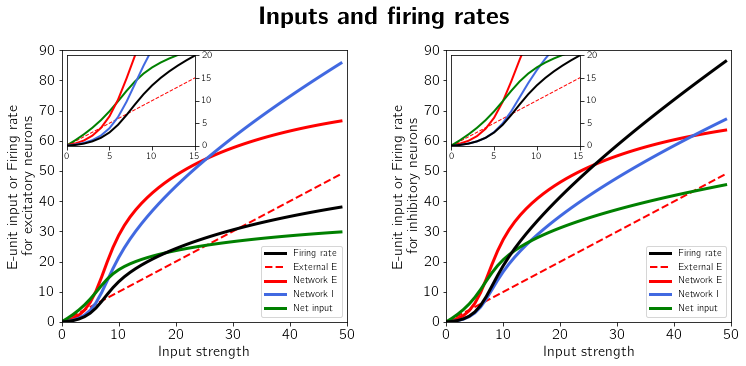

In [5]:
# original figure from Klaus
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.35, hspace=0.05)
plt.suptitle('\\textbf{Inputs and firing rates}', y=1.0, fontsize=25)

I_network = np.squeeze(I[:, :, my_t]) - stim

ax1.plot(np.arange(50), np.squeeze(R[:, i_pref, my_t]), lw=3, zorder=3, c='black')
ax1.plot(np.arange(50), np.squeeze(stim[:, i_pref]), lw=2, linestyle='dashed', c='red', zorder=1)
ax1.plot(np.arange(50), np.squeeze(I_networkE[:, i_pref, my_t]), lw=3, c='red', zorder=2)
ax1.plot(np.arange(50), np.squeeze(-IE[:, i_pref, my_t]), lw=3, c='royalblue', zorder=2)
ax1.plot(np.arange(50), np.squeeze(I[:, i_pref, my_t]), lw=3, zorder=2, c='green')

axins1 = zoomed_inset_axes(ax1, 1.5, loc=2)

axins1.plot(np.arange(50), np.squeeze(R[:, i_pref, my_t]), lw=2, zorder=3, c='black')
axins1.plot(np.arange(50), np.squeeze(I[:, i_pref, my_t]), lw=2, zorder=2, c='green')
axins1.plot(np.arange(50), np.squeeze(I_networkE[:, i_pref, my_t]), lw=2, c='red', zorder=2)
axins1.plot(np.arange(50), np.squeeze(-IE[:, i_pref, my_t]), lw=2, c='royalblue', zorder=2)
axins1.plot(np.arange(50), np.squeeze(stim[:, i_pref]), lw=1, linestyle='dashed', c='red', zorder=1)

# sub region of the original image
x1, x2, y1, y2 = 0, 15, 0, 20
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)

plt.xticks(visible=True)
plt.yticks(visible=True)
axins1.tick_params(right=True, top=False, left=False, bottom=True, labelright=True, labeltop=False, labelbottom=True, labelleft=False)

ax1.set_xlim(0, 50)
ax1.set_ylim(0, 90)
ax1.set_xlabel('Input strength', fontsize=15)
ax1.set_ylabel('E-unit input or Firing rate\n for excitatory neurons', fontsize=15)
ax1.legend(['Firing rate',  'External E', 'Network E', 'Network I', 'Net input'], loc=4, prop={'size': 10})
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.plot(np.arange(50), np.squeeze(R[:, ssn.params.get('NI') + i_pref[0][0], my_t]), lw=3, c='black', zorder=3)
ax2.plot(np.arange(50), np.squeeze(stim[:, i_pref]), lw=2, linestyle='dashed', c='red', zorder=1)
ax2.plot(np.arange(50), np.squeeze(I_networkI[:, i_pref, my_t]), lw=3, c='red', zorder=2)
ax2.plot(np.arange(50), np.squeeze(-II[:, i_pref, my_t]), lw=3, c='royalblue', zorder=2)
ax2.plot(np.arange(50), np.squeeze(I[:, ssn.params.get('NI') + i_pref[0][0], my_t]), lw=3, c='green', zorder=2)

axins2 = zoomed_inset_axes(ax2, 1.5, loc=2)

axins2.plot(np.arange(50), np.squeeze(R[:, i_pref, my_t]), lw=2, zorder=3, c='black')
axins2.plot(np.arange(50), np.squeeze(stim[:, i_pref]), lw=1, linestyle='dashed', c='red', zorder=1)
axins2.plot(np.arange(50), np.squeeze(I_networkI[:, i_pref, my_t]), lw=2, c='red', zorder=2)
axins2.plot(np.arange(50), np.squeeze(-II[:, i_pref, my_t]), lw=2, c='royalblue', zorder=2)
axins2.plot(np.arange(50), np.squeeze(I[:, i_pref, my_t]), lw=2, zorder=2, c='green')

# sub region of the original image
x1, x2, y1, y2 = 0, 15, 0, 20
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

plt.xticks(visible=True)
plt.yticks(visible=True)
axins2.tick_params(right=True, top=False, left=False, bottom=True, labelright=True, labeltop=False, labelbottom=True, labelleft=False)

ax2.set_xlim(0, 50)
ax2.set_ylim(0, 90)
ax2.set_xlabel('Input strength', fontsize=15)
ax2.set_ylabel('E-unit input or Firing rate\n for inhibitory neurons', fontsize=15)
ax2.legend(['Firing rate',  'External E', 'Network E', 'Network I', 'Net input'], loc=4, prop={'size': 10})
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

##### Original plots we wanted to replicate

In [6]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=180, NI=180, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(-90))


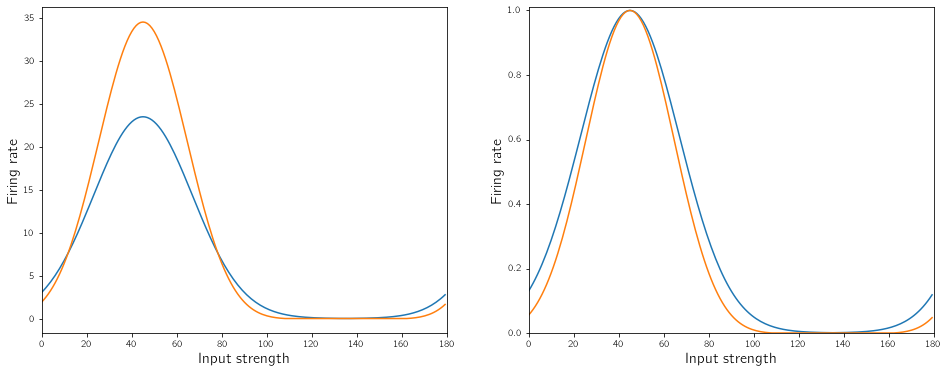

In [7]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, 180), np.squeeze(R[19:100:20, ssn.params.get('idxE'), my_t]).T)
ax1.set_xlabel('Input strength', fontsize=15)
ax1.set_ylabel('Firing rate', fontsize=15)
ax1.set_xlim([0,180])

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, 180), (np.squeeze(R[19:100:20, ssn.params.get('idxE'), my_t]) / np.max(R[19:100:20, ssn.params.get('idxE'), my_t], axis=2)).T)
ax2.set_xlabel('Input strength', fontsize=15)
ax2.set_ylabel('Firing rate', fontsize=15)
ax2.set_xlim([0,180])
ax2.set_ylim([0,1.01])

#plt.savefig('')
plt.show()

##### Figure 1G. Sublinear response summation for multiple stimuli

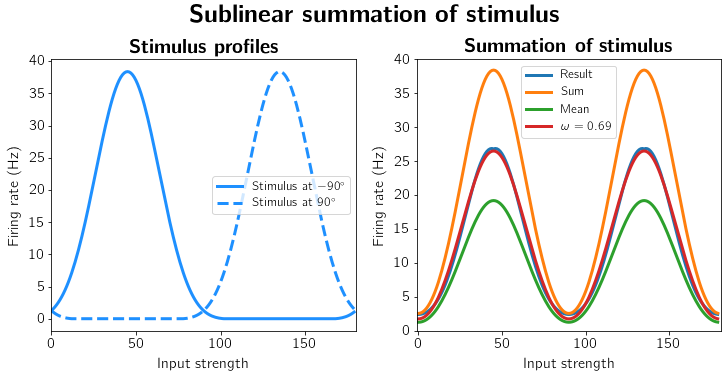

In [8]:
R = np.zeros((3, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=50, I1_stim_I=50, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=50, I1_stim_I=50, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# two stimuli, at th_stim = -90 and th_stim = +90
ssn.params.update({'stimulus': stim_neg90 + stim_pos90})
R[2, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
ax1.plot(np.arange(180), np.squeeze(R[0, ssn.params.get('idxE'), my_t]), c='dodgerblue', lw=3, zorder=1)
ax1.set_xlabel('Input strength', fontsize=15)
ax1.set_ylabel('Firing rate', fontsize=15)
ax1.set_xlim([0,180])

ax1.plot(np.arange(180), np.squeeze(R[1, ssn.params.get('idxE'), my_t]), c='dodgerblue', linestyle='dashed', lw=3, zorder=1)
ax1.set_xlabel('Input strength', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_xlim([0,180])
ax1.legend(['Stimulus at $-90^\circ$', 'Stimulus at $90^\circ$'],  prop={'size': 12.5})

ax2.plot(np.arange(180), np.squeeze(R[2, ssn.params.get('idxE'), my_t]), lw=3, zorder=1)
ax2.plot(np.arange(180), np.squeeze(R[0, ssn.params.get('idxE'), my_t]) + np.squeeze(R[1, ssn.params.get('idxE'), my_t]), lw=3, zorder=1)
ax2.plot(np.arange(180), 1 / 2 * np.squeeze(R[0, ssn.params.get('idxE'), my_t]) + 1 / 2 * np.squeeze(R[1, ssn.params.get('idxE'), my_t]), lw=3, zorder=1)
ax2.plot(np.arange(180), 0.69 * np.squeeze(R[0, ssn.params.get('idxE'), my_t]) + 0.69 * np.squeeze(R[1, ssn.params.get('idxE'), my_t]), lw=3, zorder=1)
ax2.legend(['Result', 'Sum', 'Mean', '$\\omega$ = 0.69'],  prop={'size': 12.5})
ax2.set_xlim([-1,181])
ax2.set_ylim([0, 40])

ax2.set_xlabel('Input strength', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax1.set_title('\\textbf{Stimulus profiles}', fontsize=20)
ax1.xaxis.labelpad = 7
ax1.yaxis.labelpad = 7

ax2.set_title('\\textbf{Summation of stimulus}', fontsize=20)
ax2.xaxis.labelpad = 7
ax2.yaxis.labelpad = 7

plt.suptitle('\\textbf{Sublinear summation of stimulus}', y=1.025, fontsize=25)
# plt.savefig('/Users/miguel/Desktop/plot3.pdf')
plt.show()

##### Figure 1H. Increasingly winner-take-all responses for increasingly divergent contrasts of the two stimuli.

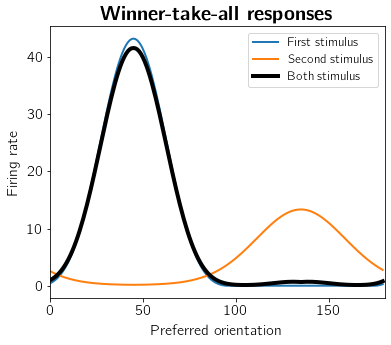

In [9]:
R = np.zeros((3, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=70, I1_stim_I=70, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# two stimuli, at th_stim = -90 and th_stim = +90
ssn.params.update({'stimulus': stim_neg90 + stim_pos90})
R[2, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

ax1.plot(np.arange(180), np.squeeze(R[0, ssn.params.get('idxE'), my_t]), lw=2, zorder=1)
ax1.plot(np.arange(180), np.squeeze(R[1, ssn.params.get('idxE'), my_t]), lw=2, zorder=2)
ax1.plot(np.arange(180), np.squeeze(R[2, ssn.params.get('idxE'), my_t]), c='black', lw=4, zorder=3)

ax1.set_xlim([0,180])
ax1.set_xlabel('Preferred orientation', fontsize=15)
ax1.set_ylabel('Firing rate', fontsize=15)
ax1.legend(['First stimulus', 'Second stimulus', 'Both stimulus'], prop={'size': 12.5})

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.xaxis.labelpad = 7
ax1.yaxis.labelpad = 7

ax1.set_title('\\textbf{Winner-take-all responses}', fontsize=20)

#plt.savefig('/Users/miguel/Desktop/plot4.pdf')
plt.show()

##### Set width, strength and location of top-down attention input to excitatory and inhibitory neurons

In [246]:
I_att_E, sigma_att_E = 1.5, np.deg2rad(60)
I_att_I, sigma_att_I = 1., np.deg2rad(120)
th_att = np.deg2rad(90)

#### Combination of a strong stimulus with a weak top-down signal

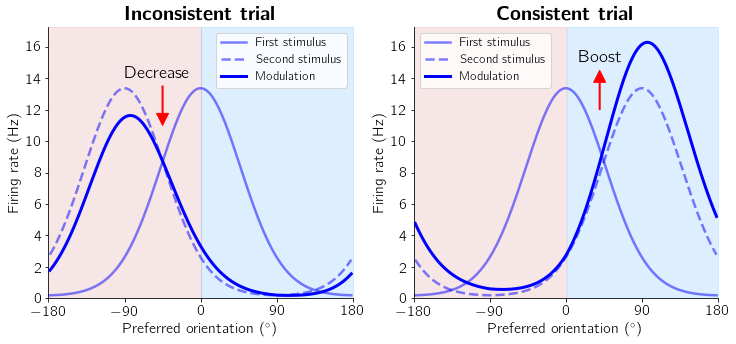

In [316]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=200, NI=200, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(0))
ssn.run()
R = np.zeros((6, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# single stimulus at th_stim = 0
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(0))
R[5, :, :] = ssn.run()

I_att_E, sigma_att_E = 1.15, np.deg2rad(60)
I_att_I, sigma_att_I = 1., np.deg2rad(160)
th_att = np.deg2rad(0)

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att, att=False)
stim_att_neg90 = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

I_att_E, sigma_att_E = 1.5, np.deg2rad(120)
I_att_I, sigma_att_I = 1., np.deg2rad(240)
th_att = np.deg2rad(180)

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att, att=False)
stim_att_pos90 = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

# stimulus and top-down signal combined
ssn.params.update({'stimulus': stim_neg90 + stim_att_neg90})
R[3, :, :] = ssn.run()

ssn.params.update({'stimulus': stim_pos90 + stim_att_pos90})
R[4, :, :] = ssn.run()


min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

max_R0 = np.max(np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]))
max_R1 = np.max(np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]))
max_R2 = np.max(np.squeeze(R[2, np.where(np.abs(th) < 180), my_t]))
max_R3 = np.max(np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]))
max_R4 = np.max(np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]))
max_R5 = np.max(np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1., 1.]})

ax1.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]), c='blue', alpha=0.5, lw=2.5, zorder=1)
ax1.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]), c='blue', linestyle='dashed', lw=2.5, alpha=0.5, zorder=2)
ax1.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]), c='blue', lw=3, zorder=3)
ax1.fill_between(np.array([-180, 0]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='indianred', alpha=0.15, label='_nolegend_', zorder=0)
ax1.fill_between(np.array([1, 180]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='dodgerblue', alpha=0.15, label='_nolegend_', zorder=0)

ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{Inconsistent trial}', fontsize=20)
ax1.legend(['First stimulus', 'Second stimulus', 'Modulation'], fontsize=12.5)

ax1.annotate('Decrease', xy=(-90, 14), fontsize=17.5)
ax1.annotate('', xytext=(-45, 13.5), xy=(-45, 11), 
            arrowprops=dict(color='red', width=1.))

ax1.set_xlim([-180, 180])
ax1.set_ylim([0., np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1])])
ax1.tick_params(axis='both', which='major', labelsize=15)

ax1.set_xticks(np.arange(-180, 181, 90))

ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(True)
ax1.spines.left.set_visible(True)
ax1.spines.right.set_visible(False)

ax2.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]), c='blue', alpha=0.5, lw=2.5, zorder=1)
ax2.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]), c='blue', linestyle='dashed', lw=2.5, alpha=0.5, zorder=2)
ax2.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]), c='blue', lw=3, zorder=3)
ax2.fill_between(np.array([-180, 0]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='indianred', alpha=0.15, label='_nolegend_', zorder=0)
ax2.fill_between(np.array([1, 180]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='dodgerblue', alpha=0.15, label='_nolegend_', zorder=0)
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Consistent trial}', fontsize=20)
ax2.legend(['Stimulus', 'Attentional signal', 'Both'], fontsize=10)
ax2.legend(['First stimulus', 'Second stimulus', 'Modulation'], fontsize=12.5)

ax2.annotate('Boost', xy=(15, 15), fontsize=17.5)
ax2.annotate('', xytext=(40, 12), xy=(40, 14.5), 
            arrowprops=dict(color='red', width=1.))

ax2.set_xlim([-180, 180])
ax2.set_ylim([0., np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1])])
ax2.tick_params(axis='both', which='major', labelsize=15)

ax2.set_xticks(np.arange(-180, 181, 90))

ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(True)
ax2.spines.left.set_visible(True)
ax2.spines.right.set_visible(False)

#fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/plot3.png')
plt.show()

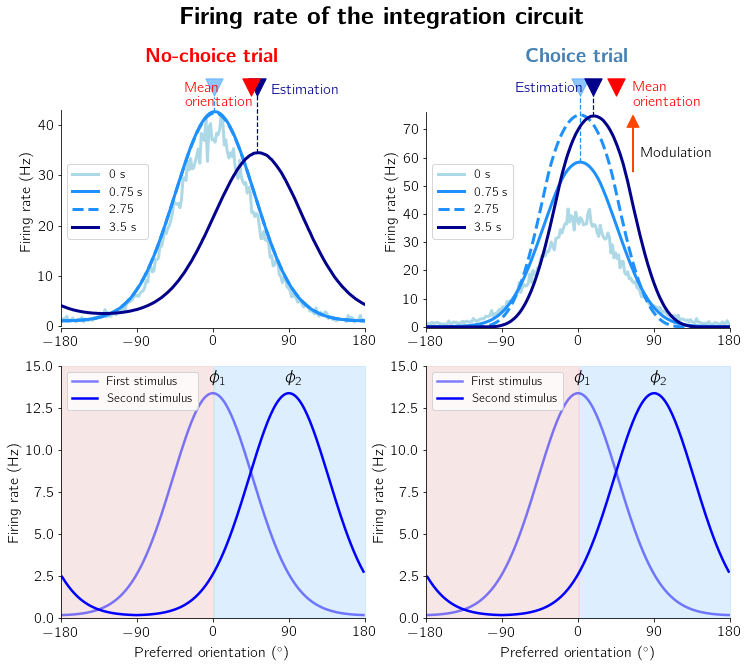

In [490]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 10))

data = df_005_bump
r_IC = r_ic_005_bump
ntrial = 33

plt.subplots_adjust(wspace=0.2, hspace=0.15)
plt.suptitle('\\textbf{Firing rate of the integration circuit}', y=0.975, fontsize=25)

max_fr = np.max([r_IC[0, ntrial, :], r_IC[85, ntrial, :], r_IC[270, ntrial, :], r_IC[-2, ntrial, :]])

ax1.scatter(data.ph1[ntrial], max_fr + 5, marker='v', color='dodgerblue', s=300, alpha=0.5, zorder=1, label='_nolegend_')
ax1.scatter(data.ph_last[ntrial], max_fr + 5, marker='v', color='darkblue', s=300, alpha=1., zorder=2, label='_nolegend_')
ax1.scatter(data.average[ntrial], max_fr + 5, marker='v', color='red', s=300, alpha=1., zorder=2, label='_nolegend_')
ax1.annotate('Estimation', (data.average[ntrial] + 25, max_fr + 3.5), color='darkblue', fontsize=15) 
ax1.annotate('Mean\n orientation', (data.ph1[ntrial] - 35, max_fr + 1), color='red', fontsize=15) 

ax1.plot(np.linspace(-180, 180, 200), r_IC[0, ntrial, :], c='lightblue', lw=3, zorder=1)
ax1.plot(np.linspace(-180, 180, 200), r_IC[85, ntrial, :], c='dodgerblue', lw=3, zorder=2)
ax1.plot(np.linspace(-180, 180, 200), r_IC[270, ntrial, :], c='dodgerblue', linestyle='dashed', lw=3, zorder=2)
ax1.plot(np.linspace(-180, 180, 200), r_IC[-2, ntrial, :], c='darkblue', lw=3, zorder=3)

ax1.vlines(data.ph1[ntrial],  max(r_IC[85, ntrial, :]),  max_fr + 3, color='dodgerblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')
ax1.vlines(data.ph_last[ntrial],  max(r_IC[-2, ntrial, :]),  max_fr + 5, color='darkblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')

ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(True)
ax1.spines.left.set_visible(True)
ax1.spines.right.set_visible(False)

ax1.set_xlim([-180, 180])

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.legend(['0 s', '0.75 s', '2.75', '3.5 s'], fontsize=13, loc='center left')
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)

ax1.set_ylim(bottom=-0.25)
ax1.set_xticks(np.arange(-180, 181, 90))
ax1.set_yticks(np.arange(0, math.ceil(max_fr), 10))
ax1.spines.left.set_bounds((0, math.ceil(max_fr)))
ax1.xaxis.labelpad = 7.5


data = df_005_bump
r_IC = r_ic_005_bump
ntrial = 39

max_fr = np.max([r_IC[0, ntrial, :], r_IC[85, ntrial, :], r_IC[270, ntrial, :], r_IC[-2, ntrial, :]])

ax2.scatter(data.ph1[ntrial], max_fr + 10, marker='v', color='dodgerblue', s=300, alpha=.5, zorder=1, label='_nolegend_')
ax2.scatter(data.ph_last[ntrial], max_fr + 10, marker='v', color='darkblue', s=300, alpha=1., zorder=2, label='_nolegend_')
ax2.scatter(data.average[ntrial], max_fr + 10, marker='v', color='red', s=300, alpha=1., zorder=2, label='_nolegend_')
ax2.annotate('Estimation', (data.ph1[ntrial] - 75, max_fr + 8), color='darkblue', fontsize=15) 
ax2.annotate('Mean\n orientation', (data.average[ntrial] + 20, max_fr + 3), color='red', fontsize=15) 

ax2.plot(np.linspace(-180, 180, 200), r_IC[0, ntrial, :], c='lightblue', lw=3, zorder=1)
ax2.plot(np.linspace(-180, 180, 200), r_IC[85, ntrial, :], c='dodgerblue', lw=3, zorder=2)
ax2.plot(np.linspace(-180, 180, 200), r_IC[270, ntrial, :], c='dodgerblue', linestyle='dashed', lw=3, zorder=2)
ax2.plot(np.linspace(-180, 180, 200), r_IC[-2, ntrial, :], c='darkblue', lw=3, zorder=3)

ax2.vlines(data.ph1[ntrial],  max(r_IC[85, ntrial, :]),  max_fr + 7, color='dodgerblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')
ax2.vlines(data.ph_last[ntrial],  max(r_IC[-2, ntrial, :]),  max_fr + 7, color='darkblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')

ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(True)
ax2.spines.left.set_visible(True)
ax2.spines.right.set_visible(False)

ax2.set_xlim([-180, 180])

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.legend(['0 s', '0.75 s', '2.75', '3.5 s'], fontsize=13, loc='center left')
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)

ax2.set_ylim(bottom=-0.25)
ax2.set_xticks(np.arange(-180, 181, 90))
ax2.set_yticks(np.arange(0, math.ceil(max_fr), 10))
ax2.spines.left.set_bounds((0, math.ceil(max_fr)))
ax2.xaxis.labelpad = 7.5


ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=200, NI=200, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(0))
ssn.run()
R = np.zeros((6, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# single stimulus at th_stim = 0
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(0))
R[5, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

max_R0 = np.max(np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]))
max_R1 = np.max(np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]))
max_R2 = np.max(np.squeeze(R[2, np.where(np.abs(th) < 180), my_t]))
max_R3 = np.max(np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]))
max_R4 = np.max(np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]))
max_R5 = np.max(np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]))

ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]), c='blue', alpha=0.5, lw=2.5, zorder=1)
ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]), c='blue', lw=2.5, alpha=1., zorder=2)
ax3.fill_between(np.array([-180, 0]), 0, 15, color='indianred', alpha=0.15, label='_nolegend_', zorder=0)
ax3.fill_between(np.array([1, 180]), 0, 15, color='dodgerblue', alpha=0.15, label='_nolegend_', zorder=0)

ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{No-choice trial}', c='red', y=1.025, fontsize=20)
ax3.legend(['First stimulus', 'Second stimulus', 'Modulation'], fontsize=12.5)

ax3.annotate('$\phi_1$', xy=(-5, 14), fontsize=17.5)
ax3.annotate('$\phi_2$', xy=(85, 14), fontsize=17.5)

ax3.set_xlim([-180, 180])
ax3.set_ylim([0., 15.])
ax3.tick_params(axis='both', which='major', labelsize=15)

ax3.set_xticks(np.arange(-180, 181, 90))
ax3.set_yticks(np.arange(0, 16, 2.5))

ax3.spines.top.set_visible(False)
ax3.spines.bottom.set_visible(True)
ax3.spines.left.set_visible(True)
ax3.spines.right.set_visible(False)

ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]), c='blue', alpha=0.5, lw=2.5, zorder=1)
ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]), c='blue', lw=2.5, alpha=1., zorder=2)
ax4.fill_between(np.array([-180, 0]), 0, 15, color='indianred', alpha=0.15, label='_nolegend_', zorder=0)
ax4.fill_between(np.array([1, 180]), 0, 15, color='dodgerblue', alpha=0.15, label='_nolegend_', zorder=0)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Choice trial}', c='steelblue', y=1.025, fontsize=20)
ax4.legend(['Stimulus', 'Attentional signal', 'Both'], fontsize=10)
ax4.legend(['First stimulus', 'Second stimulus', 'Modulation'], fontsize=12.5)

ax4.annotate('$\phi_1$', xy=(-5, 14), fontsize=17.5)
ax4.annotate('$\phi_2$', xy=(85, 14), fontsize=17.5)

ax4.set_xlim([-180, 180])
ax4.set_ylim([0., 15.])
ax4.tick_params(axis='both', which='major', labelsize=15)

ax4.set_xticks(np.arange(-180, 181, 90).astype(int))
ax4.set_yticks(np.arange(0, 16, 2.5))

ax4.spines.top.set_visible(False)
ax4.spines.bottom.set_visible(True)
ax4.spines.left.set_visible(True)
ax4.spines.right.set_visible(False)

ax3.xaxis.labelpad = 7
ax4.xaxis.labelpad = 7

ax2.annotate('Modulation', xy=(75, 60), fontsize=15)
ax2.annotate('', xytext=(65, 55), xy=(65, 75), 
            arrowprops=dict(color='orangered', width=1.))

#fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/plot3.png')
plt.show()

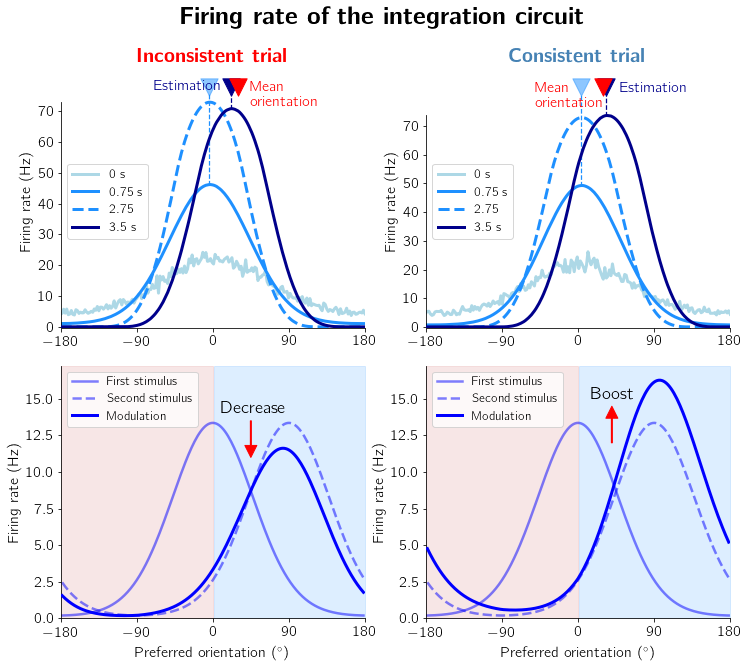

In [573]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 10))

data = df_005_bump
r_IC = r_ic_005_bump
ntrial = 78

plt.subplots_adjust(wspace=0.2, hspace=0.15)
plt.suptitle('\\textbf{Firing rate of the integration circuit}', y=0.975, fontsize=25)

max_fr = np.max([r_IC[0, ntrial, :], r_IC[85, ntrial, :], r_IC[270, ntrial, :], r_IC[-2, ntrial, :]])

ax1.scatter(data.ph1[ntrial], max_fr + 5, marker='v', color='dodgerblue', s=300, alpha=0.5, zorder=1, label='_nolegend_')
ax1.scatter(data.ph_last[ntrial], max_fr + 5, marker='v', color='darkblue', s=300, alpha=1., zorder=2, label='_nolegend_')
ax1.scatter(data.average[ntrial], max_fr + 5, marker='v', color='red', s=300, alpha=1., zorder=2, label='_nolegend_')

ax1.plot(np.linspace(-180, 180, 200), r_IC[0, ntrial, :], c='lightblue', lw=3, zorder=1)
ax1.plot(np.linspace(-180, 180, 200), r_IC[85, ntrial, :], c='dodgerblue', lw=3, zorder=2)
ax1.plot(np.linspace(-180, 180, 200), r_IC[270, ntrial, :], c='dodgerblue', linestyle='dashed', lw=3, zorder=2)
ax1.plot(np.linspace(-180, 180, 200), r_IC[-2, ntrial, :], c='darkblue', lw=3, zorder=3)

ax1.vlines(data.ph1[ntrial],  max(r_IC[85, ntrial, :]),  max_fr + 3, color='dodgerblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')
ax1.vlines(data.ph_last[ntrial],  max(r_IC[-2, ntrial, :]),  max_fr + 5, color='darkblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')

ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(True)
ax1.spines.left.set_visible(True)
ax1.spines.right.set_visible(False)

ax1.set_xlim([-180, 180])

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.legend(['0 s', '0.75 s', '2.75', '3.5 s'], fontsize=13, loc='center left')
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)

ax1.set_ylim(bottom=-0.25)
ax1.set_xticks(np.arange(-180, 181, 90))
ax1.set_yticks(np.arange(0, math.ceil(max_fr), 10))
ax1.spines.left.set_bounds((0, math.ceil(max_fr)))
ax1.xaxis.labelpad = 7.5


data = df_005_bump
r_IC = r_ic_005_bump
ntrial = 234

max_fr = np.max([r_IC[0, ntrial, :], r_IC[85, ntrial, :], r_IC[270, ntrial, :], r_IC[-2, ntrial, :]])

ax2.scatter(data.ph1[ntrial], max_fr + 10, marker='v', color='dodgerblue', s=300, alpha=.5, zorder=1, label='_nolegend_')
ax2.scatter(data.ph_last[ntrial], max_fr + 10, marker='v', color='darkblue', s=300, alpha=1., zorder=2, label='_nolegend_')
ax2.scatter(data.average[ntrial], max_fr + 10, marker='v', color='red', s=300, alpha=1., zorder=2, label='_nolegend_')
ax2.annotate('Estimation', (data.average[ntrial] + 20, max_fr + 8), color='darkblue', fontsize=15) 
ax2.annotate('Mean\n orientation', (data.ph1[ntrial] - 55, max_fr + 3), color='red', fontsize=15) 

ax2.plot(np.linspace(-180, 180, 200), r_IC[0, ntrial, :], c='lightblue', lw=3, zorder=1)
ax2.plot(np.linspace(-180, 180, 200), r_IC[85, ntrial, :], c='dodgerblue', lw=3, zorder=2)
ax2.plot(np.linspace(-180, 180, 200), r_IC[270, ntrial, :], c='dodgerblue', linestyle='dashed', lw=3, zorder=2)
ax2.plot(np.linspace(-180, 180, 200), r_IC[-2, ntrial, :], c='darkblue', lw=3, zorder=3)

ax2.vlines(data.ph1[ntrial],  max(r_IC[85, ntrial, :]),  max_fr + 7, color='dodgerblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')
ax2.vlines(data.ph_last[ntrial],  max(r_IC[-2, ntrial, :]),  max_fr + 7, color='darkblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')

ax2.spines.top.set_visible(False)
ax2.spines.bottom.set_visible(True)
ax2.spines.left.set_visible(True)
ax2.spines.right.set_visible(False)

ax2.set_xlim([-180, 180])

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.legend(['0 s', '0.75 s', '2.75', '3.5 s'], fontsize=13, loc='center left')
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)

ax2.set_ylim(bottom=-0.25)
ax2.set_xticks(np.arange(-180, 181, 90))
ax2.set_yticks(np.arange(0, math.ceil(max_fr), 10))
ax2.spines.left.set_bounds((0, math.ceil(max_fr)))
ax2.xaxis.labelpad = 7.5


ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=200, NI=200, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(0))
ssn.run()
R = np.zeros((6, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# single stimulus at th_stim = 0
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(0))
R[5, :, :] = ssn.run()

I_att_E, sigma_att_E = 1.15, np.deg2rad(60)
I_att_I, sigma_att_I = 1., np.deg2rad(160)
th_att = np.deg2rad(0)

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att, att=False)
stim_att_neg90 = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

I_att_E, sigma_att_E = 1.5, np.deg2rad(120)
I_att_I, sigma_att_I = 1., np.deg2rad(240)
th_att = np.deg2rad(180)

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att, att=False)
stim_att_pos90 = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

# stimulus and top-down signal combined
ssn.params.update({'stimulus': stim_neg90 + stim_att_neg90})
R[3, :, :] = ssn.run()

ssn.params.update({'stimulus': stim_pos90 + stim_att_pos90})
R[4, :, :] = ssn.run()


min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

max_R0 = np.max(np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]))
max_R1 = np.max(np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]))
max_R2 = np.max(np.squeeze(R[2, np.where(np.abs(th) < 180), my_t]))
max_R3 = np.max(np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]))
max_R4 = np.max(np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]))
max_R5 = np.max(np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]))

ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]), c='blue', alpha=0.5, lw=2.5, zorder=1)
ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]), c='blue', linestyle='dashed', lw=2.5, alpha=0.5, zorder=2)
ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]), c='blue', lw=3, zorder=3)
ax3.fill_between(np.array([-180, 0]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='indianred', alpha=0.15, label='_nolegend_', zorder=0)
ax3.fill_between(np.array([1, 180]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='dodgerblue', alpha=0.15, label='_nolegend_', zorder=0)

ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{Inconsistent trial}', c='red', y=1.025, fontsize=20)
ax3.legend(['First stimulus', 'Second stimulus', 'Modulation'], fontsize=12.5)

ax3.annotate('Decrease', xy=(10, 14), fontsize=17.5)
ax3.annotate('', xytext=(45, 13.5), xy=(45, 11), 
            arrowprops=dict(color='red', width=1.))

ax3.set_xlim([-180, 180])
ax3.set_ylim([0., np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1])])
ax3.tick_params(axis='both', which='major', labelsize=15)

ax3.set_xticks(np.arange(-180, 181, 90))

ax3.spines.top.set_visible(False)
ax3.spines.bottom.set_visible(True)
ax3.spines.left.set_visible(True)
ax3.spines.right.set_visible(False)

ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[5, np.where(np.abs(th) < 180), my_t]), c='blue', alpha=0.5, lw=2.5, zorder=1)
ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]), c='blue', linestyle='dashed', lw=2.5, alpha=0.5, zorder=2)
ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]), c='blue', lw=3, zorder=3)
ax4.fill_between(np.array([-180, 0]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='indianred', alpha=0.15, label='_nolegend_', zorder=0)
ax4.fill_between(np.array([1, 180]), 0, np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1]), color='dodgerblue', alpha=0.15, label='_nolegend_', zorder=0)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Consistent trial}', c='steelblue', y=1.025, fontsize=20)
ax4.legend(['Stimulus', 'Attentional signal', 'Both'], fontsize=10)
ax4.legend(['First stimulus', 'Second stimulus', 'Modulation'], fontsize=12.5)

ax4.annotate('Boost', xy=(15, 15), fontsize=17.5)
ax4.annotate('', xytext=(40, 12), xy=(40, 14.5), 
            arrowprops=dict(color='red', width=1.))

ax4.set_xlim([-180, 180])
ax4.set_ylim([0., np.max([max_R5 + 1, max_R1 + 1, max_R4 + 1])])
ax4.tick_params(axis='both', which='major', labelsize=15)

ax4.set_xticks(np.arange(-180, 181, 90))

ax4.spines.top.set_visible(False)
ax4.spines.bottom.set_visible(True)
ax4.spines.left.set_visible(True)
ax4.spines.right.set_visible(False)

ax3.xaxis.labelpad = 7
ax4.xaxis.labelpad = 7

ax1.annotate('Estimation', (data.average[ntrial] - 100, max_fr + 3), color='darkblue', fontsize=15) 
ax1.annotate('Mean\n orientation', (data.ph1[ntrial] + 40, max_fr - 2), color='red', fontsize=15) 

#fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/plot3.png')
plt.show()

In [525]:
import pandas as pd
import math

os.chdir('/Users/miguel/Desktop/post_choice_bias/results')
os.chdir('./bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')
r_ic_005_bump = np.load('./r_ic_bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)

In [526]:
df_005_bump.loc[(df_005_bump.x2 == 60) & (df_005_bump.binchoice == -1)]

,Trial,index,x1i,x2i,x1,x2,average,bincorrect,do_choice,category,subj,init_ph_n,estim,binchoice,binrt,ph1,ph2,phd,ph_last,chosen
18,18,18,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,23.464463,-1.0,0.3272,-2.410684,23.464463,-2.102461,24.574764,18
27,27,27,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,23.421172,-1.0,0.2724,-3.080199,23.421172,-2.607974,24.441922,27
78,78,78,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,20.356097,-1.0,0.2712,-4.574433,20.356097,-4.357440,21.377579,78
161,161,161,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,20.490316,-1.0,0.2968,-5.228391,20.490316,-4.764598,21.643477,161
180,180,180,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,21.820569,-1.0,0.3566,-3.340260,21.820569,-3.008321,22.859940,180
190,190,190,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,28.301680,-1.0,0.3154,-0.869120,28.301680,-0.846452,29.244634,190
235,235,235,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,25.346460,-1.0,0.3892,-1.921535,25.346460,-1.809319,26.417856,235
237,237,237,9.0,15.0,0.0,60.0,30.0,1.0,1.0,30.0,1.0,1.0,23.830785,-1.0,0.3200,-3.467752,23.830785,-3.228257,24.879909,237


Do choice? True


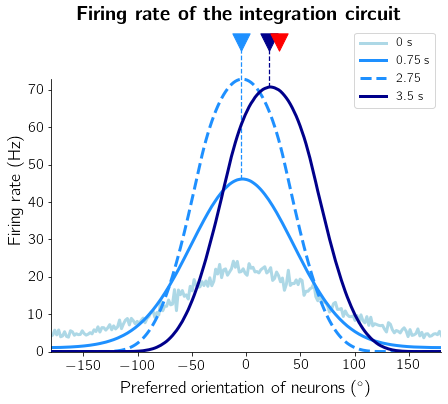

In [527]:
ntrial = 78
fig, [ax1] = plot_bump_ic(df_005_bump, r_ic_005_bump, ntrial=ntrial)

-43.20000000000001 48.6


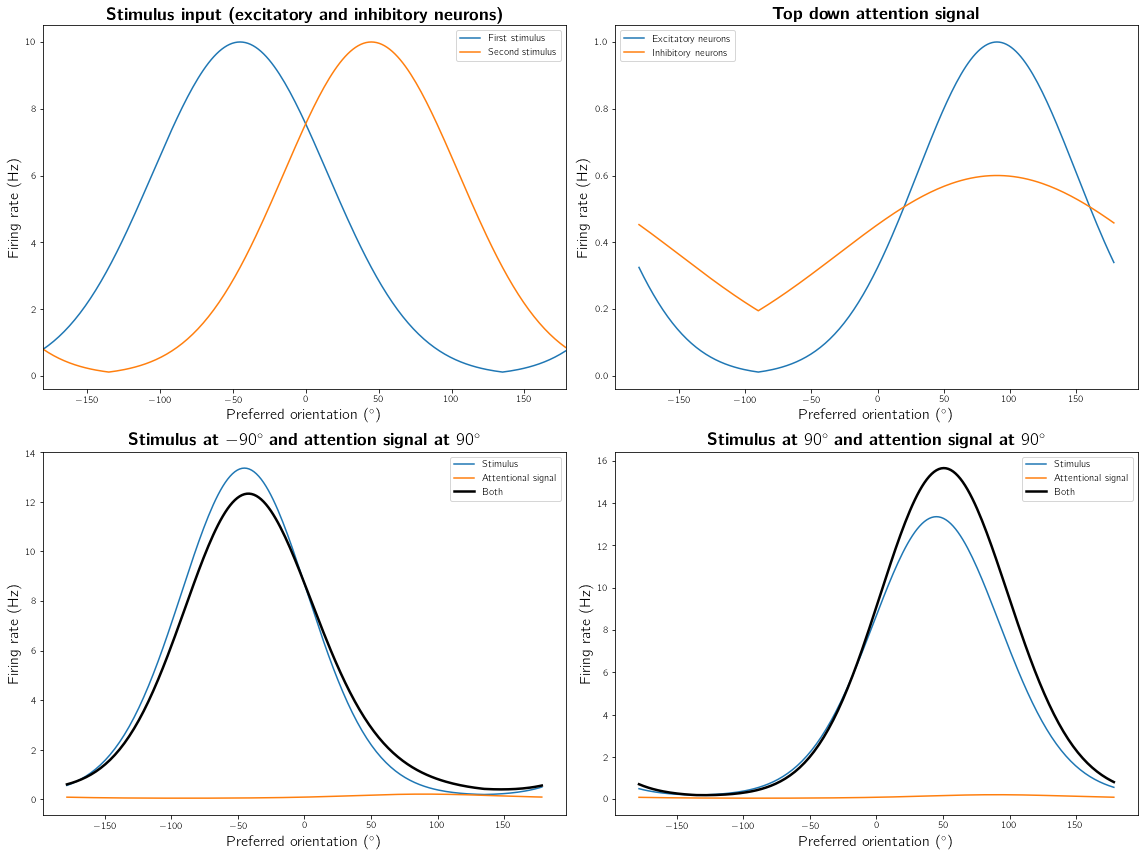

In [28]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=200, NI=200, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(0))
ssn.run()
R = np.zeros((5, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(-45))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(45))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att, att=False)
stim_att = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

# stimulus and top-down signal combined
ssn.params.update({'stimulus': stim_neg90 + stim_att})
R[3, :, :] = ssn.run()

ssn.params.update({'stimulus': stim_pos90 + stim_att})
R[4, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax1.plot(th, stim_neg90[idxE], zorder=1)
ax1.plot(th, stim_pos90[idxE], zorder=1)
ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{Stimulus input (excitatory and inhibitory neurons)}', fontsize=17.5)
ax1.legend(['First stimulus', 'Second stimulus'])
ax1.set_xlim([min(th), max(th)])

ax2 = fig.add_subplot(222)
ax2.plot(th, stim_att[idxE], zorder=1)
ax2.plot(th, stim_att[idxI], zorder=1)
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Top down attention signal}', fontsize=17.5)
ax2.legend(['Excitatory neurons', 'Inhibitory neurons'])

ax3 = fig.add_subplot(223)
ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[0, np.where(np.abs(th) < 180), my_t]), zorder=1)
ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[2, np.where(np.abs(th) < 180), my_t]), zorder=2)
ax3.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]), c='black', lw=2.5, zorder=3)
ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)
ax3.set_title('\\textbf{Stimulus at $-90^\circ$ and attention signal at $90^\circ$}', fontsize=17.5)
ax3.legend(['Stimulus', 'Attentional signal', 'Both'])

ax4 = fig.add_subplot(224)
ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[1, np.where(np.abs(th) < 180), my_t]), zorder=1)
ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[2, np.where(np.abs(th) < 180), my_t]), zorder=2)
ax4.plot(th[np.where(np.abs(th) < 180)], np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]), c='black', lw=2.5, zorder=3)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Firing rate (Hz)', fontsize=15)
ax4.set_title('\\textbf{Stimulus at $90^\circ$ and attention signal at $90^\circ$}', fontsize=17.5)
ax4.legend(['Stimulus', 'Attentional signal', 'Both'])

print(th[np.where(np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]) == np.max(R[3, np.where(np.abs(th) < 180), my_t]))[0][0]], 
      th[np.where(np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]) == np.max(R[4, np.where(np.abs(th) < 180), my_t]))[0][0]])
fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/plot3.png')
plt.show()

In [12]:
I_att_E, sigma_att_E = 1., np.deg2rad(60)
I_att_I, sigma_att_I = 0.6, np.deg2rad(120)
th_att = np.deg2rad(90)

-91.8 88.2


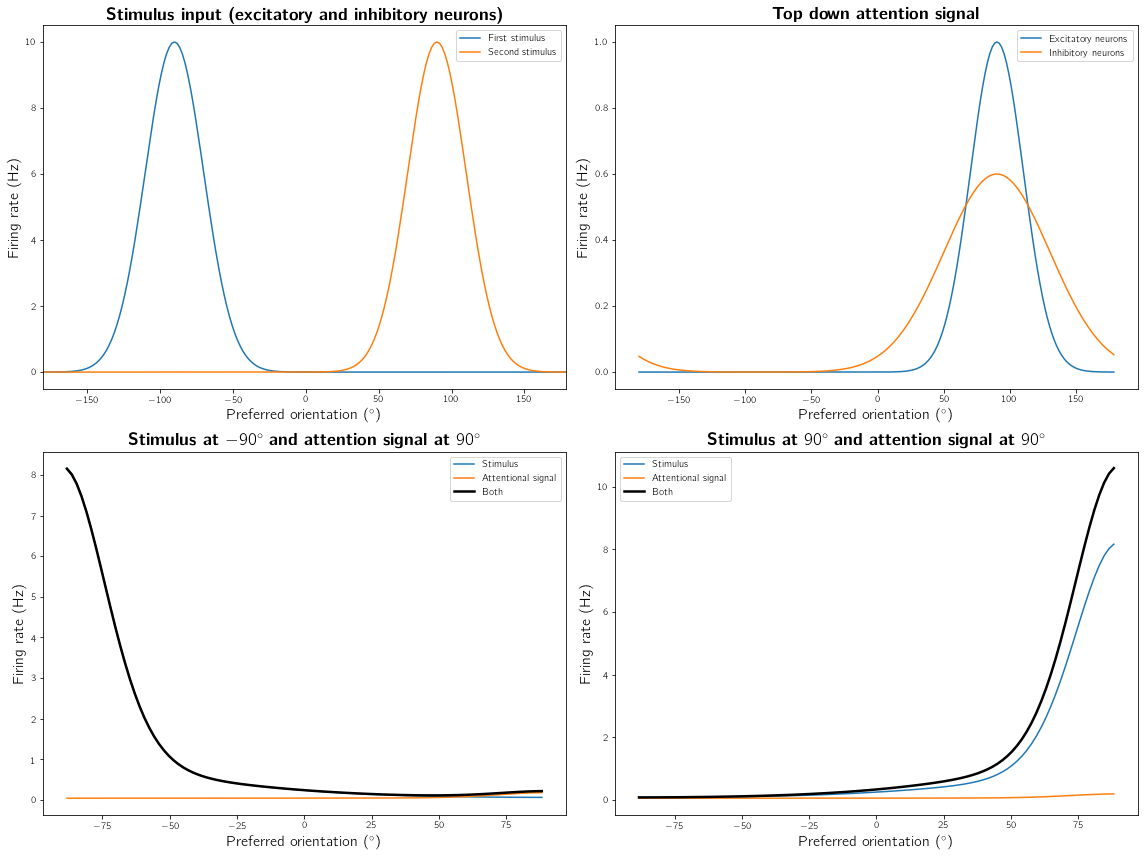

In [24]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=200, NI=200, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(20), sigma_stim_I=np.deg2rad(20),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(0))
ssn.run()
R = np.zeros((5, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att, att=False)
stim_att = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

# stimulus and top-down signal combined
ssn.params.update({'stimulus': stim_neg90 + stim_att})
R[3, :, :] = ssn.run()

ssn.params.update({'stimulus': stim_pos90 + stim_att})
R[4, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax1.plot(th, stim_neg90[idxE], zorder=1)
ax1.plot(th, stim_pos90[idxE], zorder=1)
ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{Stimulus input (excitatory and inhibitory neurons)}', fontsize=17.5)
ax1.legend(['First stimulus', 'Second stimulus'])
ax1.set_xlim([min(th), max(th)])

ax2 = fig.add_subplot(222)
ax2.plot(th, stim_att[idxE], zorder=1)
ax2.plot(th, stim_att[idxI], zorder=1)
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Top down attention signal}', fontsize=17.5)
ax2.legend(['Excitatory neurons', 'Inhibitory neurons'])

ax3 = fig.add_subplot(223)
ax3.plot(th[np.where(np.abs(th) < 90)], np.squeeze(R[0, np.where(np.abs(th) < 90), my_t]), zorder=1)
ax3.plot(th[np.where(np.abs(th) < 90)], np.squeeze(R[2, np.where(np.abs(th) < 90), my_t]), zorder=2)
ax3.plot(th[np.where(np.abs(th) < 90)], np.squeeze(R[3, np.where(np.abs(th) < 90), my_t]), c='black', lw=2.5, zorder=3)
ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)
ax3.set_title('\\textbf{Stimulus at $-90^\circ$ and attention signal at $90^\circ$}', fontsize=17.5)
ax3.legend(['Stimulus', 'Attentional signal', 'Both'])

ax4 = fig.add_subplot(224)
ax4.plot(th[np.where(np.abs(th) < 90)], np.squeeze(R[1, np.where(np.abs(th) < 90), my_t]), zorder=1)
ax4.plot(th[np.where(np.abs(th) < 90)], np.squeeze(R[2, np.where(np.abs(th) < 90), my_t]), zorder=2)
ax4.plot(th[np.where(np.abs(th) < 90)], np.squeeze(R[4, np.where(np.abs(th) < 90), my_t]), c='black', lw=2.5, zorder=3)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Firing rate (Hz)', fontsize=15)
ax4.set_title('\\textbf{Stimulus at $90^\circ$ and attention signal at $90^\circ$}', fontsize=17.5)
ax4.legend(['Stimulus', 'Attentional signal', 'Both'])

print(th[np.where(np.squeeze(R[3, np.where(np.abs(th) < 180), my_t]) == np.max(R[3, np.where(np.abs(th) < 180), my_t]))[0][0]], 
      th[np.where(np.squeeze(R[4, np.where(np.abs(th) < 180), my_t]) == np.max(R[4, np.where(np.abs(th) < 180), my_t]))[0][0]])
fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/plot3.png')
plt.show()

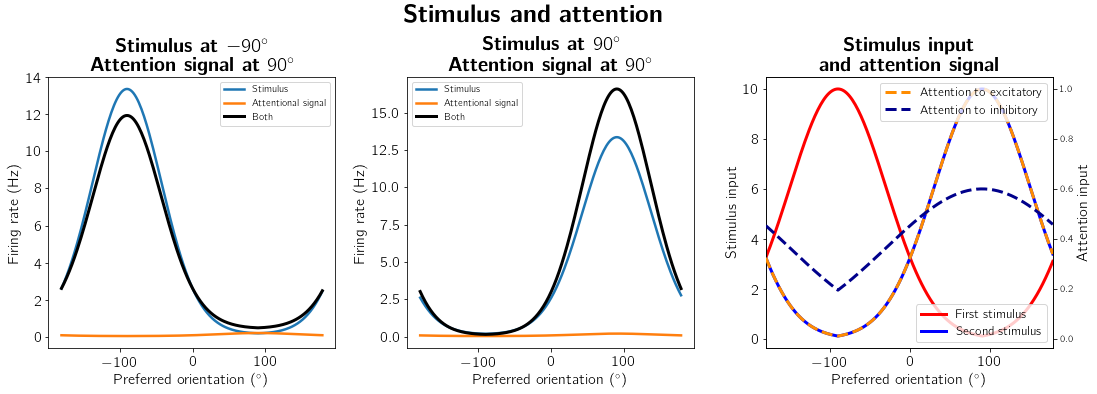

In [14]:
# FIGURE FOR BARCSSYN POSTER

ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=200, NI=200, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),
         I0_stim_E=0., I1_stim_E=10, I0_stim_I=0., I1_stim_I=10, th_stim=np.deg2rad(0))
ssn.run()
R = np.zeros((5, ssn.params.get('N'), ssn.params.get('t').shape[0]))

# single stimulus at th_stim = -90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(-90))
stim_neg90 = ssn.params.get('stimulus')
R[0, :, :] = ssn.run()

# single stimulus at th_stim = +90
ssn.prep(I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(90))
stim_pos90 = ssn.params.get('stimulus')
R[1, :, :] = ssn.run()

# weak top-down attentional modulation at +90
ssn.prep(I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att)
stim_att = ssn.params.get('stimulus')
R[2, :, :] = ssn.run()

# stimulus and top-down signal combined
ssn.params.update({'stimulus': stim_neg90 + stim_att})
R[3, :, :] = ssn.run()

ssn.params.update({'stimulus': stim_pos90 + stim_att})
R[4, :, :] = ssn.run()

min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
th = np.rad2deg(ssn.params.get('theta'))
idxE = ssn.params.get('idxE')
idxI = ssn.params.get('idxI')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.25, hspace=0.1)

ax1.plot(th, np.squeeze(R[0, ssn.params.get('idxE'), my_t]), lw=2.5, zorder=1)
ax1.plot(th, np.squeeze(R[2, ssn.params.get('idxE'), my_t]), lw=2.5, zorder=2)
ax1.plot(th, np.squeeze(R[3, ssn.params.get('idxE'), my_t]), lw=3, c='black', zorder=3)
ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{Stimulus at $-90^\circ$}\n\\textbf{Attention signal at $90^\circ$}', fontsize=20)
ax1.legend(['Stimulus', 'Attentional signal', 'Both'])

ax2.plot(th, np.squeeze(R[1, ssn.params.get('idxE'), my_t]), lw=2.5, zorder=1)
ax2.plot(th, np.squeeze(R[2, ssn.params.get('idxE'), my_t]), lw=2.5, zorder=2)
ax2.plot(th, np.squeeze(R[4, ssn.params.get('idxE'), my_t]), c='black', lw=3, zorder=3)
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Stimulus at $90^\circ$}\n\\textbf{Attention signal at $90^\circ$}', fontsize=20)
ax2.legend(['Stimulus', 'Attentional signal', 'Both'])

ax3.plot(th, stim_neg90[idxE], c='red', lw=3, zorder=1)
ax3.plot(th, stim_pos90[idxE], c='blue', lw=3, zorder=2)
ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Stimulus input', fontsize=15)
ax3.set_title('\\textbf{Stimulus input}\n\\textbf{and attention signal}', fontsize=20)
ax3.legend(['First stimulus', 'Second stimulus'], loc='lower right', prop={'size': 12.5})
ax3.set_xlim([min(th), max(th)])

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.plot(th, stim_att[idxE], c='darkorange', linestyle='dashed', lw=3, zorder=3)
ax4.plot(th, stim_att[idxI], c='darkblue',  linestyle='dashed', lw=3, zorder=4)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Attention input', fontsize=15)
ax4.legend(['Attention to excitatory', 'Attention to inhibitory'], loc='upper right', prop={'size': 12.5})

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)

plt.suptitle('\\textbf{Stimulus and attention}', y=1.075, fontsize=25)
plt.savefig('/Users/miguel/Desktop/attention_90.pdf')
plt.show()

##### Set width, strength and location of top-down attention input to excitatory and inhibitory neurons

In [15]:
I_att_E, sigma_att_E = 1, np.deg2rad(2 * 10)
I_att_I, sigma_att_I = 0.6, np.deg2rad(2 * 20)
th_att = np.deg2rad(+90)

In [16]:
ssn = SSN()
ssn.prep(batchsize=1, dt=1e-3, dt_rate=1e-3, tmax=0.8, 
         NE=180, NI=180, tauE=20e-3, tauI=10e-3, tauF=1, 
         sigma_ori=np.deg2rad(2 * 32), GEE=7.92, GIE=7.56, GEI=4.14, GII=3.24, I0E=0.0, I0I=0.0, tau_b=1e-3,          
         tcue=[0.1, 0.6], sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60),    
         I0_stim_E=0., I1_stim_E=50, I0_stim_I=0., I1_stim_I=50, th_stim=np.deg2rad(-90))

th_stims = np.arange(-180, 180, 1)

In [17]:
# tuning curves, "no attention" condition
R_no = np.zeros((400, th_stims.shape[0]))

for i in range(th_stims.shape[0]):
    ssn.prep(NE=200, NI=200, I1_stim_E=10, I1_stim_I=10, th_stim=np.deg2rad(th_stims[i]))
    r = ssn.run();
    min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
    my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
    R_no[:, i]  = np.squeeze(r[:, :, my_t])

In [18]:
# tuning curves, "attention in" condition (attention signal at 90 degrees)
R_in = np.zeros((400, th_stims.shape[0]))

ssn.prep(NE=200, NI=200, I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=th_att)
stim_att = ssn.params.get('stimulus')
    
for i in range(th_stims.shape[0]):
    ssn.prep(NE=200, NI=200, I1_stim_E=10, I1_stim_I=10, sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60), th_stim=np.deg2rad(th_stims[i]))
    ssn.params.update({'stimulus': ssn.params.get('stimulus') + stim_att})
    r = ssn.run();
    min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
    my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
    R_in[:, i]  = np.squeeze(r[:, :, my_t])

In [19]:
# tuning curves, "att out" condition (attention signal at -90 degree)
R_out = np.zeros((400, th_stims.shape[0]))

ssn.prep(NE=200, NI=200, I1_stim_E=I_att_E, I1_stim_I=I_att_I, sigma_stim_E=sigma_att_E, sigma_stim_I=sigma_att_I, th_stim=-th_att)
stim_att = ssn.params.get('stimulus')
    
for i in range(th_stims.shape[0]):
    ssn.prep(NE=200, NI=200, I1_stim_E=10, I1_stim_I=10, sigma_stim_E=np.deg2rad(60), sigma_stim_I=np.deg2rad(60), th_stim=np.deg2rad(th_stims[i]))
    ssn.params.update({'stimulus': ssn.params.get('stimulus') + stim_att})
    r = ssn.run();
    min_t = np.min(abs(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2)))
    my_t = np.where(ssn.params.get('t') - (ssn.params.get('tcue')[0] + np.diff(ssn.params.get('tcue')) / 2) == min_t)
    R_out[:, i]  = np.squeeze(r[:, :, my_t])

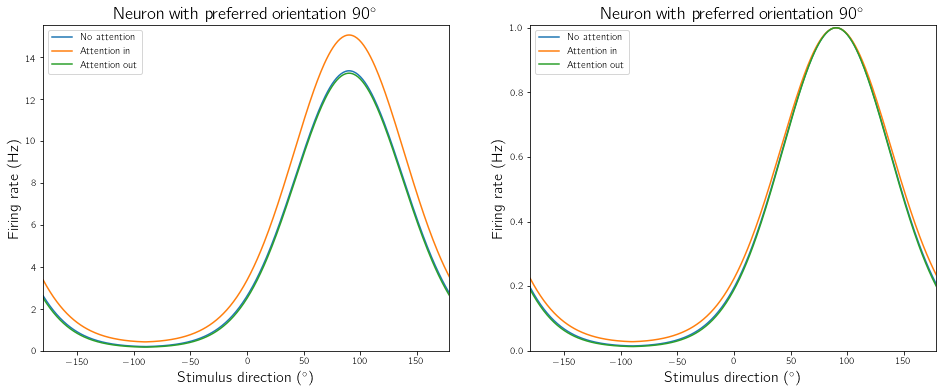

In [20]:
th = np.rad2deg(ssn.params.get('theta'))
my_neuron = np.where(th == 90)
idxE = ssn.params.get('idxE')

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(th_stims, np.squeeze(R_no[my_neuron]), zorder=1)
ax1.plot(th_stims, np.squeeze(R_in[my_neuron]), zorder=1)
ax1.plot(th_stims, np.squeeze(R_out[my_neuron]), zorder=1)
ax1.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('Neuron with preferred orientation $90^\circ$', fontsize=17.5)
ax1.legend(['No attention', 'Attention in', 'Attention out'])
ax1.set_xlim([min(th), max(th)])
ax1.set_ylim([0, max(max(np.squeeze(R_no[my_neuron])), max(np.squeeze(R_in[my_neuron])), max(np.squeeze(R_out[my_neuron]))) + 0.5])

ax2 = fig.add_subplot(122)
ax2.plot(th_stims, np.squeeze(R_no[my_neuron]) / max(np.squeeze(R_no[my_neuron])), zorder=1)
ax2.plot(th_stims, np.squeeze(R_in[my_neuron]) / max(np.squeeze(R_in[my_neuron])), zorder=1)
ax2.plot(th_stims, np.squeeze(R_out[my_neuron]) / max(np.squeeze(R_out[my_neuron])), zorder=1)
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('Neuron with preferred orientation $90^\circ$', fontsize=17.5)
ax2.legend(['No attention', 'Attention in', 'Attention out'])
ax2.set_xlim([min(th), max(th)])
ax2.set_ylim([0, 1+0.01])

plt.show()

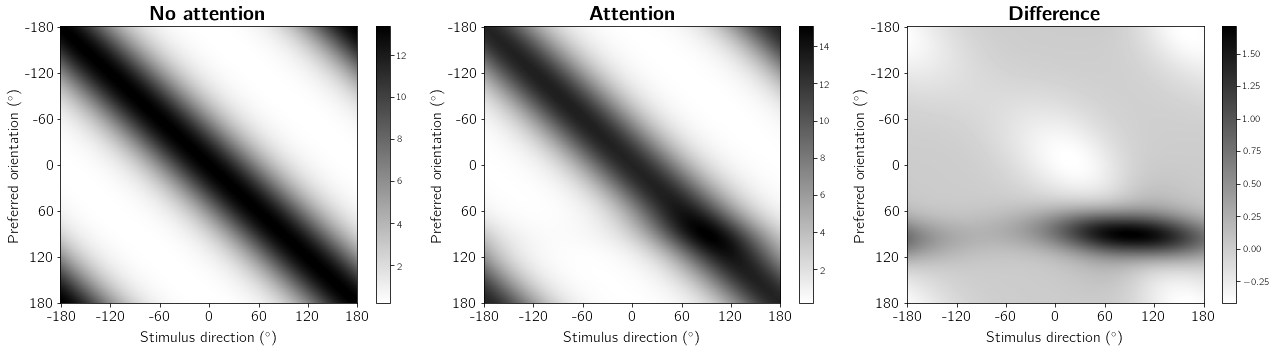

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.25, hspace=0.1)

im1 = ax1.imshow(R_no[idxE,:], cmap='gray_r', aspect='auto')
ax1.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax1.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_title('\\textbf{No attention}', fontsize=20)
fig.colorbar(im1, orientation='vertical')

ax1.set_xticks(np.linspace(0, 360, 7))
ax1.set_xticklabels(np.linspace(-180, 180, 7, dtype='int'))
ax1.set_yticks(np.linspace(0, 200, 7))
ax1.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

ax1.xaxis.labelpad = 7
ax1.yaxis.labelpad = 3

im2 = ax2.imshow(R_in[idxE,:], cmap='gray_r', aspect='auto')
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax2.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_title('\\textbf{Attention}', fontsize=20)
fig.colorbar(im2, orientation='vertical')

ax2.set_xticks(np.linspace(0, 360, 7))
ax2.set_xticklabels(np.linspace(-180, 180, 7, dtype='int'))
ax2.set_yticks(np.linspace(0, 200, 7))
ax2.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

ax2.xaxis.labelpad = 7
ax2.yaxis.labelpad = 3

im3 = ax3.imshow(R_in[idxE,:] - R_no[idxE,:], cmap='gray_r', aspect='auto')
ax3.set_xlabel('Stimulus direction $(^\circ)$', fontsize=15)
ax3.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_title('\\textbf{Difference}', fontsize=20)
fig.colorbar(im3, orientation='vertical')

ax3.set_xticks(np.linspace(0, 360, 7))
ax3.set_xticklabels(np.linspace(-180, 180, 7, dtype='int'))
ax3.set_yticks(np.linspace(0, 200, 7))
ax3.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

ax3.xaxis.labelpad = 7
ax3.yaxis.labelpad = 3

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
plt.savefig('/Users/miguel/Desktop/plot1.pdf')
plt.show()

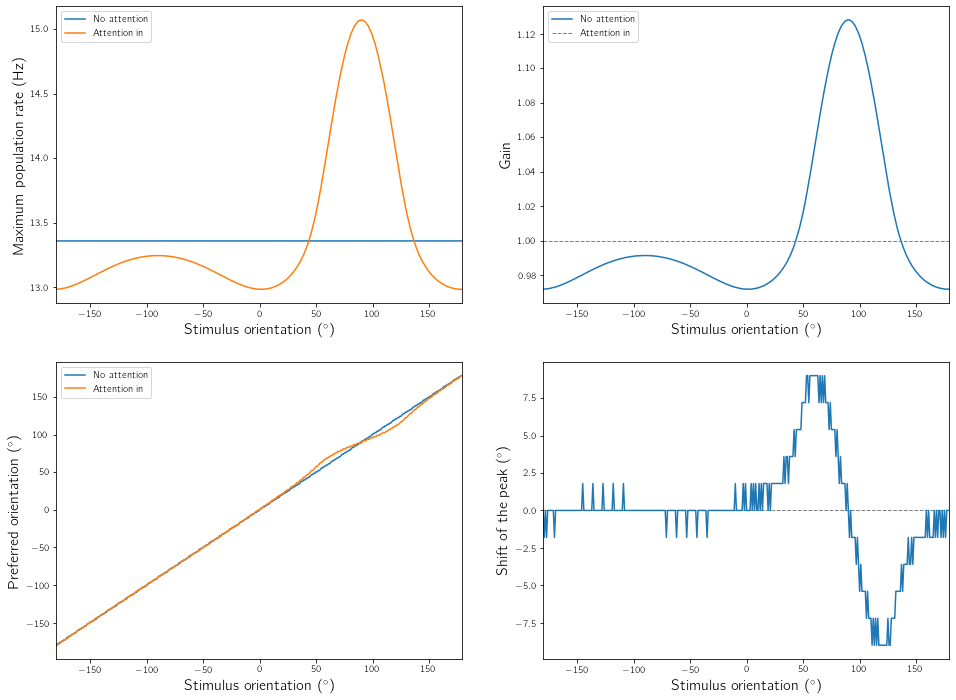

In [22]:
i_max = np.where(R_no[idxE,:] == np.max(R_no[idxE,:], axis=0)[np.newaxis,:])
theta_max_no = ssn.params.get('theta')[i_max[0]]
i_max = np.where(R_in[idxE,:] == np.max(R_in[idxE,:], axis=0)[np.newaxis,:])
theta_max_in = ssn.params.get('theta')[i_max[0]]


fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax1.plot(th_stims, np.max(R_no[idxE,:], axis=0), zorder=1)
ax1.plot(th_stims, np.max(R_in[idxE,:], axis=0), zorder=1)
ax1.set_xlabel('Stimulus orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Maximum population rate (Hz)', fontsize=15)
ax1.legend(['No attention', 'Attention in'])
ax1.set_xlim([min(th_stims), max(th_stims)])

ax2 = fig.add_subplot(222)
ax2.plot(th_stims, np.max(R_in[idxE,:], axis=0) / np.max(R_no[idxE,:], axis=0), zorder=1)
ax2.plot(th_stims, np.repeat(1, th_stims.shape[0]), '--', lw=1, c='grey', zorder=1)
ax2.set_xlabel('Stimulus orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Gain', fontsize=15)
ax2.legend(['No attention', 'Attention in'])
ax2.set_xlim([min(th_stims), max(th_stims)])

ax3 = fig.add_subplot(223)
ax3.plot(th_stims, np.rad2deg(theta_max_no), zorder=1)
ax3.plot(th_stims, np.rad2deg(theta_max_in), zorder=1)
ax3.set_xlabel('Stimulus orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.legend(['No attention', 'Attention in'])
ax3.set_xlim([min(th_stims), max(th_stims)])

ax4 = fig.add_subplot(224)
ax4.plot(th_stims, np.rad2deg(circ_dist(theta_max_in, theta_max_no)), zorder=2)
ax4.plot(th_stims, np.repeat(0, th_stims.shape[0]), '--', lw=1, c='grey', zorder=1)
ax4.set_xlabel('Stimulus orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Shift of the peak $(^\circ)$', fontsize=15)
ax4.set_xlim([min(th_stims), max(th_stims)])

#fig.tight_layout()
#plt.savefig('/Users/miguel/Desktop/plot2.pdf')
plt.show()

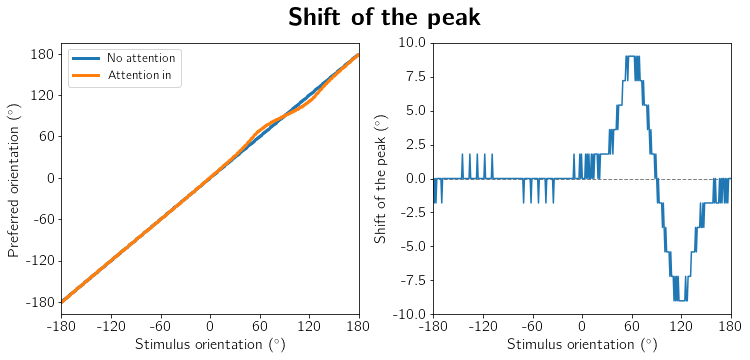

In [23]:
i_max = np.where(R_no[idxE,:] == np.max(R_no[idxE,:], axis=0)[np.newaxis,:])
theta_max_no = ssn.params.get('theta')[i_max[0]]
i_max = np.where(R_in[idxE,:] == np.max(R_in[idxE,:], axis=0)[np.newaxis,:])
theta_max_in = ssn.params.get('theta')[i_max[0]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.25, hspace=0.1)

ax1.plot(th_stims, np.rad2deg(theta_max_no), lw=3, zorder=1)
ax1.plot(th_stims, np.rad2deg(theta_max_in), lw=3, zorder=1)
ax1.set_xlabel('Stimulus orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.legend(['No attention', 'Attention in'], prop={'size': 12.5})
ax1.set_xlim([min(th_stims), max(th_stims)])

ax2.plot(th_stims, np.rad2deg(circ_dist(theta_max_in, theta_max_no)), zorder=2)
ax2.plot(th_stims, np.repeat(0, th_stims.shape[0]), '--', lw=1, c='grey', zorder=1)
ax2.set_xlabel('Stimulus orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Shift of the peak $(^\circ)$', fontsize=15)
ax2.set_xlim([min(th_stims), max(th_stims)])

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax1.set_xticks(np.linspace(-180, 180, 7))
ax1.set_xticklabels(np.linspace(-180, 180, 7, dtype='int'))
ax1.set_yticks(np.linspace(-180, 180, 7))
ax1.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

ax2.set_xticks(np.linspace(-180, 180, 7))
ax2.set_xticklabels(np.linspace(-180, 180, 7, dtype='int'))
ax2.set_yticks(np.linspace(-10, 10, 9))
ax2.set_yticklabels(np.linspace(-10, 10, 9))

plt.suptitle('\\textbf{Shift of the peak}', fontsize=25)
plt.savefig('/Users/miguel/Desktop/plot2.pdf')
plt.show()